In [86]:
import pandas as pd

HrStat = pd.read_csv("/Users/leomccarthy/Documents/Projects/Horse_racing/FlatStats/flatstats_04_09_19-2.csv", delimiter=',', header = 0) 
HrRes = pd.read_csv("/Users/leomccarthy/Documents/Projects/Horse_racing/RBD results/RBDResultsSep-Mar.csv", delimiter=',', header = 0) 

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
from datetime import datetime

HrStat["RACE_TIME"] = HrStat["RACE_TIME"] + "pm"

HrStat["RACE_TIME"] = pd.to_datetime(HrStat["RACE_TIME"].astype(str),format = '%I:%M%p').dt.strftime("%H:%M:%S")
HrRes['Time'] = pd.to_datetime(HrRes['Time'],format = '%I:%M%p').dt.strftime("%H:%M:%S")



In [88]:
HrRes["ID"] = HrRes["Date"].astype(str) + HrRes["Time"].astype(str) + HrRes["Stall"].astype(str)

In [89]:
HrStat["ID"] = HrStat["RACE_DATE"].astype(str) + HrStat["RACE_TIME"].astype(str) + HrStat["DRAWN"].astype(str) + ".0"

In [90]:
HrData = pd.merge(HrStat,HrRes[['ID', 'Place', 'Horse','Industry SP', "SP Fav", "Betfair SP"]], on= 'ID')

In [91]:
HrData = HrData.assign(Win=0)
HrData.loc[HrData['Place'] == "1", 'Win'] = 1

In [100]:
HrPredictors = HrData.drop(['RACE_DATE', 'RACE_TIME', 'COURSE','TRAINER', 'JOCKEY',"HORSE",'FORM', 'FORM_D','SIRE', 
                            'DAM','DAM_SIRE', 'OWNER','EVENT_ID','SELECTION_ID', 'ID', 'Place', 'Horse','R_CARD_NO',
                            "Betfair SP","SP Fav"
                           ], axis = 1)

HrPredictors["LTO_POS"].fillna(999, inplace = True)
HrPredictors.fillna("NotAvail", inplace = True)


In [101]:
from sklearn import preprocessing

cat_cols = HrPredictors.columns[HrPredictors.dtypes==object].tolist()
le = preprocessing.LabelEncoder()

HrPredictors[cat_cols] = HrPredictors[cat_cols].apply(lambda col: 
                                                      le.fit_transform(col))

In [146]:
X = HrPredictors.drop(["Win",'BF_WIN', 'BF_POS','ODDS','Industry SP'], axis = 1)

#X = HrPredictors[final_features]
y = HrPredictors.loc[:,['Win','Industry SP']]



Index(['GOING', 'TRACK_TYPE', 'AGES', 'HORSE_TYPE', 'GENDERS', 'RIDER_TYPE',
       'CONDITIONS', 'RACE_TYPE', 'PRIZE_1', 'O_CLASS', 'DISTANCE', 'RUNNERS',
       'LAST_RAN', 'LTO_POS', 'AGE', 'WEIGHT', 'HEADGEAR', 'ALLOWANCE',
       'DRAWN', 'J_PARETO', 'T_PARETO', 'S_PARETO', 'BF_PLACE', 'RATING',
       'RANK', 'PROB', 'J_SCORE', 'T_SCORE', 'S_SCORE', 'GENDER', 'TFI',
       'AE_ALL', 'AE_50', 'AE_28', 'ROI_ALL', 'ROI_50', 'ROI_28', 'RUNS_ALL',
       'RUNS_28', 'PLC_ALL', 'PLC_50', 'PLC_28', 'DS_WIN', 'RS_WIN', 'TF2_365',
       'TF2_84', 'TF2_28', 'TF2_14', 'TF2_7', 'TOT_RUNS', 'G_3', 'LTO_SP_RUN',
       'LTO_SR_POS'],
      dtype='object')

In [120]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

boruta_feature_selector = BorutaPy(RandomForestClassifier(), n_estimators='auto', verbose=2, random_state=4242, max_iter = 100, perc = 50)
fs = boruta_feature_selector.fit(X.values, y["Win"].values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	53
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	9
Rejected: 	34
Iteration: 	16 / 100
Confirmed: 	10
Tentative: 	7
Reject

In [121]:
X = X.loc[:, fs.support_ == 1]

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [148]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

X_train, y_train2 = rus.fit_resample(X_train, y_train['Win'])

In [22]:
from sklearn.model_selection import cross_val_score, cross_val_predict,RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, precision_score
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost import XGBRanker 
import math
from sklearn.preprocessing import MinMaxScaler

In [149]:
param_grid = {
        
        'silent': [False],
        'max_depth': [3,6,8,10,15],
        'learning_rate': [0.001, 0.01, 0.05 ,0.1, 0.2],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100,200,600], 
        'scale_pos_weight':[1,3,5,8] }


clf = xgb.XGBClassifier(objective = 'binary:logistic',nthread = 7)


Random_search = RandomizedSearchCV(clf, param_distributions = param_grid, n_iter = 100,scoring = 'precision',cv = 4)

Search_result = Random_search.fit(X_train,y_train2)

In [150]:
clf = Search_result.best_estimator_

In [154]:
test_preds = clf.predict_proba(X_test)

bets = np.where((test_preds[:,1] > 0.5) & (y_test["Industry SP"] > 2), 1,0)

confusion_matrix(bets, y_test["Win"])


array([[3307,  250],
       [1533,  337]])

In [155]:
PL = sum(y_test.loc[(bets == 1) & (y_test.loc[:,'Win'] == 1),'Industry SP']) - (bets==1).sum()
SR = len(y_test.loc[(bets == 1) & (y_test['Win'] == 1),])/(bets==1).sum() *100
ROI = PL/(bets==1).sum() * 100

print('Profit =', PL ,"pts",' Number of bets =',(bets==1).sum(), 'which is',
      round((bets==1).sum()/9), 'per day','and ROI =',round(ROI,2),"%" ,"and SR =",
      round(SR,1),"%", sep = None)

Profit = -286.2799999999984 pts  Number of bets = 1870 which is 208.0 per day and ROI = -15.31 % and SR = 18.0 %


In [144]:
oddsProbs = pd.DataFrame({'probs_pred': prob_win[:,1], 'probs_odds': list(1/HrPredictors["Industry SP"])}, columns=['probs_pred', 'probs_odds'])

NameError: name 'prob_win' is not defined

In [267]:
bets = oddsProbs.loc[oddsProbs['probs_pred'] > oddsProbs['probs_odds'] + 0.29,].index

Int64Index([    0,     1,     5,     9,    20,    29,    45,    48,    49,
               51,
            ...
            21664, 21669, 21670, 21671, 21673, 21675, 21683, 21685, 21693,
            21699],
           dtype='int64', length=6243)

In [268]:
betframe = HrPredictors.loc[bets,]
betframe
betframe.loc[betframe["Win"] == 1,"Industry SP"].sum()

3277.5

In [207]:
PL = sum(HrPredictors.loc[(bets == 1) & (HrPredictors.loc[:,'Win'] == 1),'Industry SP']) - (bets==1).sum()
SR = len(HrPredictors.loc[(bets == 1) & (HrPredictors['Win'] == 1),])/(bets==1).sum() *100
ROI = PL/(bets==1).sum() * 100

print('Profit =', PL ,"pts",' Number of bets =',(bets==1).sum(), 'which is',
      round((bets==1).sum()/9), 'per day','and ROI =',round(ROI,2),"%" ,"and SR =",
      round(SR,1),"%", sep = None)

ValueError: operands could not be broadcast together with shapes (716,) (21706,) 

In [235]:
fit = clf.fit(X,y)

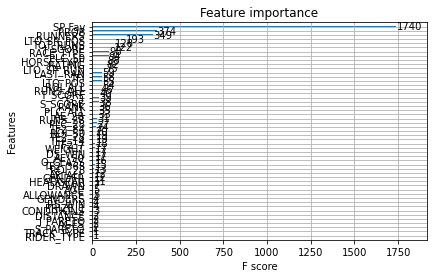

In [236]:
importances = fit.feature_importances_

plot_importance(fit)
plt.show()


In [237]:
fit.get_booster().get_score(importance_type='weight')

{'LTO_SR_POS': 193,
 'SP Fav': 1740,
 'ROI_ALL': 54,
 'RANK': 36,
 'HORSE_TYPE': 88,
 'PROB': 374,
 'O_CLASS': 16,
 'RUNNERS': 349,
 'J_SCORE': 122,
 'AE_50': 17,
 'LAST_RAN': 59,
 'TOT_RUNS': 128,
 'RUNS_ALL': 46,
 'RATING': 82,
 'LTO_SP_RUN': 75,
 'TF2_84': 24,
 'GENDER': 12,
 'RACE_TYPE': 98,
 'PLC_28': 27,
 'PLC_50': 94,
 'PLC_ALL': 35,
 'LTO_POS': 55,
 'RUNS_28': 31,
 'DS_WIN': 17,
 'S_PARETO': 2,
 'G_3': 39,
 'TFI': 58,
 'AE_ALL': 12,
 'T_SCORE': 40,
 'DRAWN': 7,
 'AGES': 2,
 'AE_28': 33,
 'CONDITIONS': 3,
 'TF2_14': 19,
 'HEADGEAR': 11,
 'S_SCORE': 38,
 'ROI_28': 13,
 'TF2_28': 19,
 'PRIZE_1': 4,
 'WEIGHT': 17,
 'RIDER_TYPE': 1,
 'TF2_7': 18,
 'ALLOWANCE': 5,
 'ROI_50': 20,
 'TF2_365': 15,
 'RS_WIN': 4,
 'AGE': 5,
 'GENDERS': 4,
 'J_PARETO': 2,
 'TRACK_TYPE': 1,
 'DISTANCE': 2}